# Regime-Switching Classifier for CPI-Yield Prediction

This notebook implements a **minimal regime-switching classifier** that predicts **binned changes in short-term yields around CPI releases**.

**Key Features:**
- Event-based modeling using CPI announcement dates
- Standardized CPI surprise as the active factor
- Background variable (yield curve slope) to define regimes
- Separate classifiers per regime
- Simple Markov chain over regimes for mixing predictions

**Full Evaluation:**
- Per-bin precision, recall, F1-score
- False positive and false negative analysis
- Confusion matrices by regime

In [1]:
import sys
from pathlib import Path
from typing import Dict, Tuple

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

from src.models.prepare_data import prepare_event_data, create_train_test_split
from src.utils.logging_utils import setup_logging
setup_logging()

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print('Imports complete!')

Imports complete!


In [2]:
# Configuration
TARGET_YIELD = 'y_2y'
BACKGROUND_VAR = 'slope_10y_2y'
N_REGIMES = 3
BIN_EDGES = [-np.inf, -0.10, -0.03, 0.03, 0.10, np.inf]
BIN_LABELS = ['Large Down (<-10bp)', 'Small Down (-10 to -3bp)', 'Neutral (-3 to +3bp)', 'Small Up (+3 to +10bp)', 'Large Up (>+10bp)']
BIN_SHORT = ['LD', 'SD', 'N', 'SU', 'LU']
TEST_SIZE = 0.3
FEATURE_COLS = ['S_CPI', BACKGROUND_VAR]
REGIME_NAMES = ['Flat/Inverted', 'Normal', 'Steep']

print('='*60)
print('CONFIGURATION')
print('='*60)
print(f'Target: {TARGET_YIELD}')
print(f'Background: {BACKGROUND_VAR}')
print(f'Regimes: {N_REGIMES}')
print(f'Bins: {len(BIN_LABELS)}')
print(f'Test Size: {TEST_SIZE*100:.0f}%')

CONFIGURATION
Target: y_2y
Background: slope_10y_2y
Regimes: 3
Bins: 5
Test Size: 30%


In [3]:
# Step 1: Load Data
print('Loading event-level dataset...')
events_df = prepare_event_data(target_yield=TARGET_YIELD, prediction_horizon=0)
yield_change_col = f'{TARGET_YIELD}_change'

print(f'\nLoaded {len(events_df)} CPI events')
print(f'Date range: {events_df["date"].min().date()} to {events_df["date"].max().date()}')
events_df.head()

Loading event-level dataset...
2025-12-03 19:09:02 - src.models.prepare_data - INFO - Preparing event-based CPI-Bond Yield dataset...
2025-12-03 19:09:02 - src.models.prepare_data - INFO - Loading Fed panel...
2025-12-03 19:09:02 - src.data.merge_panel - INFO - Building Fed panel...
2025-12-03 19:09:02 - src.data.merge_panel - INFO - Loading FRED data...
2025-12-03 19:09:02 - src.data.fred_loader - INFO - Merging 10 FRED series into daily panel...
2025-12-03 19:09:02 - src.data.fred_loader - INFO - Computed slope_10y_2y = y_10y - y_2y
2025-12-03 19:09:02 - src.data.fred_loader - INFO - Computed CPI YoY change
2025-12-03 19:09:02 - src.data.fred_loader - INFO - Saved processed FRED panel to /home/bitzaven/CodingProjects/ExamplesFixedIncomeModelling/data/processed/fred_daily_panel.parquet
2025-12-03 19:09:02 - src.data.fred_loader - INFO - Merged panel shape: (28826, 13)
2025-12-03 19:09:02 - src.data.merge_panel - INFO - Loading FedWatch probability data...
2025-12-03 19:09:02 - src.dat

,date,data_period,cpi_shock_mom,cpi_shock_yoy,cpi_shock_magnitude,cpi_level,y_2y_before,y_2y_change,y_2y_lagged,yield_lagged,yield_volatility,gdp,unemployment,fed_funds,slope_10y_2y,cpi_shock_x_fed_funds,cpi_shock_x_unemployment,cpi_shock_x_volatility
0,1994-02-17,1947-01,NaN,2.515723,NaN,21.48,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,NaN,NaN,NaN
1,1994-02-17,1947-02,0.651769,2.515723,0.651769,21.62,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,2.118250,4.301676,0.025366
2,1994-02-17,1947-03,1.757632,2.515723,1.757632,22.00,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,5.712303,11.600370,0.068405
3,1994-02-17,1947-04,0.000000,2.515723,0.000000,22.00,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,0.000000,0.000000,0.000000
4,1994-02-17,1947-05,-0.227273,2.515723,0.227273,21.95,4.44,0.06,4.44,4.44,0.038919,10939.116,6.6,3.25,1.5,-0.738636,-1.500000,-0.008845


In [4]:
# Step 2: Feature Engineering
cpi_mean = events_df['cpi_shock_mom'].mean()
cpi_std = events_df['cpi_shock_mom'].std()
events_df['S_CPI'] = (events_df['cpi_shock_mom'] - cpi_mean) / cpi_std

events_df['delta_y_bin'] = pd.cut(events_df[yield_change_col], bins=BIN_EDGES, labels=list(range(len(BIN_LABELS))), include_lowest=True).astype(int)

print('='*60)
print('FEATURE ENGINEERING')
print('='*60)
print(f'CPI Shock MoM: mean={cpi_mean:.4f}%, std={cpi_std:.4f}%')
print(f'S_CPI range: [{events_df["S_CPI"].min():.2f}, {events_df["S_CPI"].max():.2f}]')

print('\nYield Change Bin Distribution:')
bin_counts = events_df['delta_y_bin'].value_counts().sort_index()
for i, count in bin_counts.items():
    pct = count / len(events_df) * 100
    bar = '█' * int(pct)
    print(f'  Bin {i} ({BIN_SHORT[i]:>2}): {count:4d} ({pct:5.1f}%) {bar}')

FEATURE ENGINEERING
CPI Shock MoM: mean=0.2701%, std=0.3328%
S_CPI range: [-6.13, 5.09]

Yield Change Bin Distribution:
  Bin 0 (LD):   50 (  5.7%) █████
  Bin 1 (SD):  127 ( 14.4%) ██████████████
  Bin 2 ( N):  264 ( 30.0%) ██████████████████████████████
  Bin 3 (SU):  404 ( 45.9%) █████████████████████████████████████████████
  Bin 4 (LU):   35 (  4.0%) ███


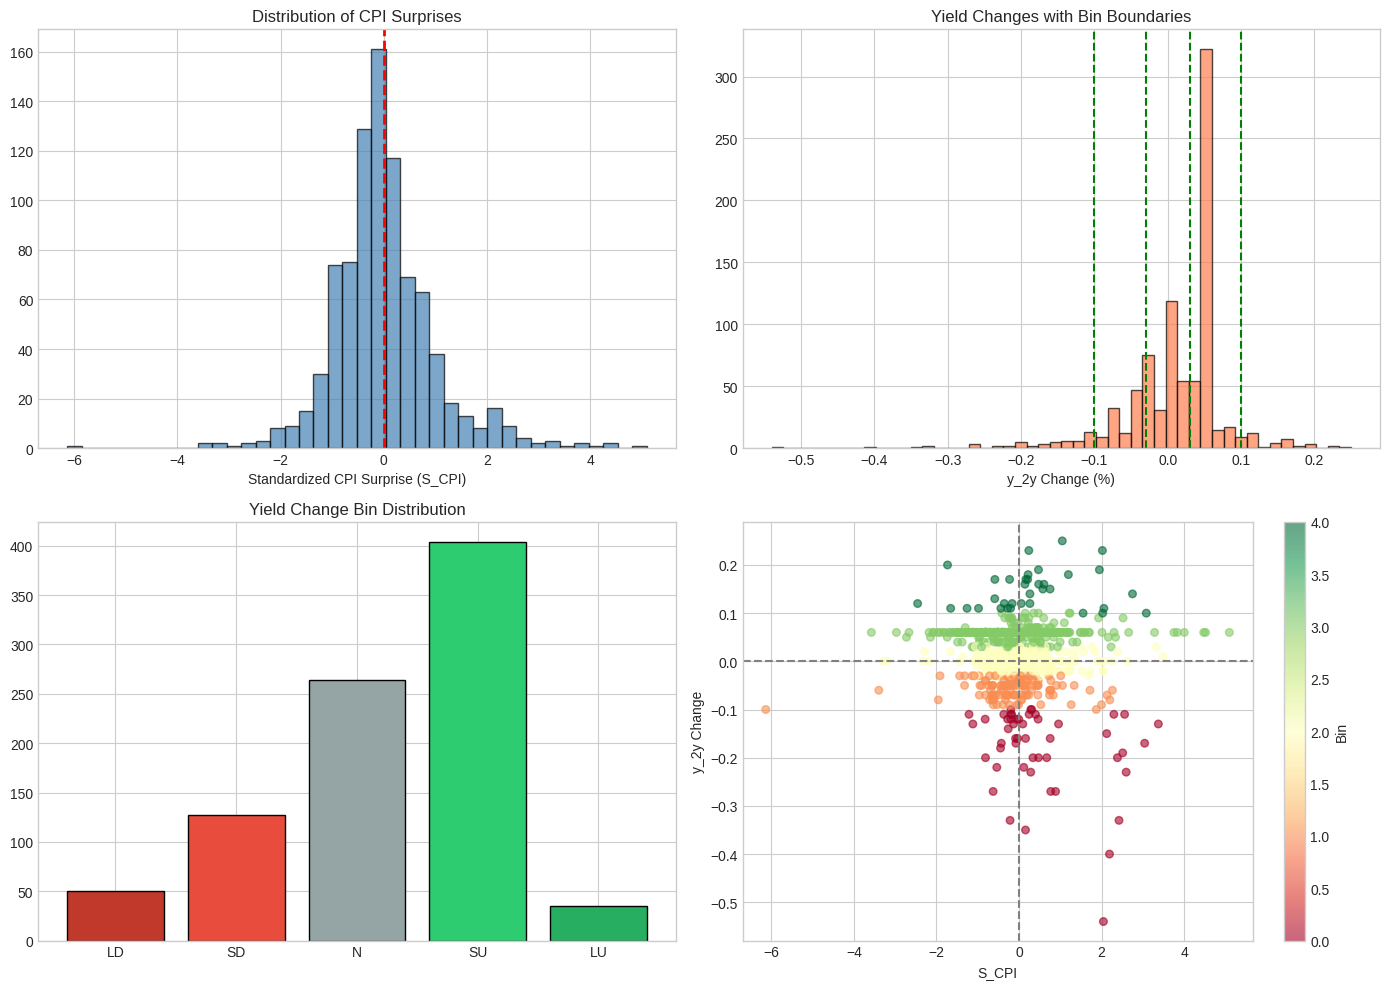

In [5]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#c0392b', '#e74c3c', '#95a5a6', '#2ecc71', '#27ae60']

axes[0,0].hist(events_df['S_CPI'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0,0].set_xlabel('Standardized CPI Surprise (S_CPI)')
axes[0,0].set_title('Distribution of CPI Surprises')

axes[0,1].hist(events_df[yield_change_col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
for edge in BIN_EDGES[1:-1]: axes[0,1].axvline(x=edge, color='green', linestyle='--', linewidth=1.5)
axes[0,1].set_xlabel(f'{TARGET_YIELD} Change (%)')
axes[0,1].set_title('Yield Changes with Bin Boundaries')

axes[1,0].bar(range(len(BIN_LABELS)), bin_counts.values, color=colors, edgecolor='black')
axes[1,0].set_xticks(range(len(BIN_LABELS)))
axes[1,0].set_xticklabels(BIN_SHORT)
axes[1,0].set_title('Yield Change Bin Distribution')

scatter = axes[1,1].scatter(events_df['S_CPI'], events_df[yield_change_col], c=events_df['delta_y_bin'], cmap='RdYlGn', alpha=0.6, s=30)
axes[1,1].axhline(y=0, color='gray', linestyle='--'); axes[1,1].axvline(x=0, color='gray', linestyle='--')
axes[1,1].set_xlabel('S_CPI'); axes[1,1].set_ylabel(f'{TARGET_YIELD} Change')
plt.colorbar(scatter, ax=axes[1,1], label='Bin')

plt.tight_layout()
plt.show()

In [6]:
# Step 3: Regime Clustering
bg_values = events_df[BACKGROUND_VAR].dropna().values.reshape(-1, 1)
regime_clusterer = KMeans(n_clusters=N_REGIMES, random_state=42, n_init=10)
regime_clusterer.fit(bg_values)

events_df['regime'] = np.nan
valid_mask = events_df[BACKGROUND_VAR].notna()
events_df.loc[valid_mask, 'regime'] = regime_clusterer.predict(events_df.loc[valid_mask, BACKGROUND_VAR].values.reshape(-1, 1))

regime_means = events_df.groupby('regime')[BACKGROUND_VAR].mean().sort_values()
regime_mapping = {old: new for new, old in enumerate(regime_means.index)}
events_df['regime'] = events_df['regime'].map(regime_mapping).astype(int)

print('='*60)
print('REGIME CLUSTERING')
print('='*60)
for regime in range(N_REGIMES):
    mask = events_df['regime'] == regime
    r_df = events_df[mask]
    print(f'\nRegime {regime} ({REGIME_NAMES[regime]}):')
    print(f'  Count: {len(r_df)} ({len(r_df)/len(events_df)*100:.1f}%)')
    print(f'  Slope: [{r_df[BACKGROUND_VAR].min():.2f}, {r_df[BACKGROUND_VAR].max():.2f}], mean={r_df[BACKGROUND_VAR].mean():.2f}')

REGIME CLUSTERING

Regime 0 (Flat/Inverted):
  Count: 283 (32.2%)
  Slope: [-2.09, 0.71], mean=0.06

Regime 1 (Normal):
  Count: 497 (56.5%)
  Slope: [0.72, 1.82], mean=1.38

Regime 2 (Steep):
  Count: 100 (11.4%)
  Slope: [1.84, 2.85], mean=2.29


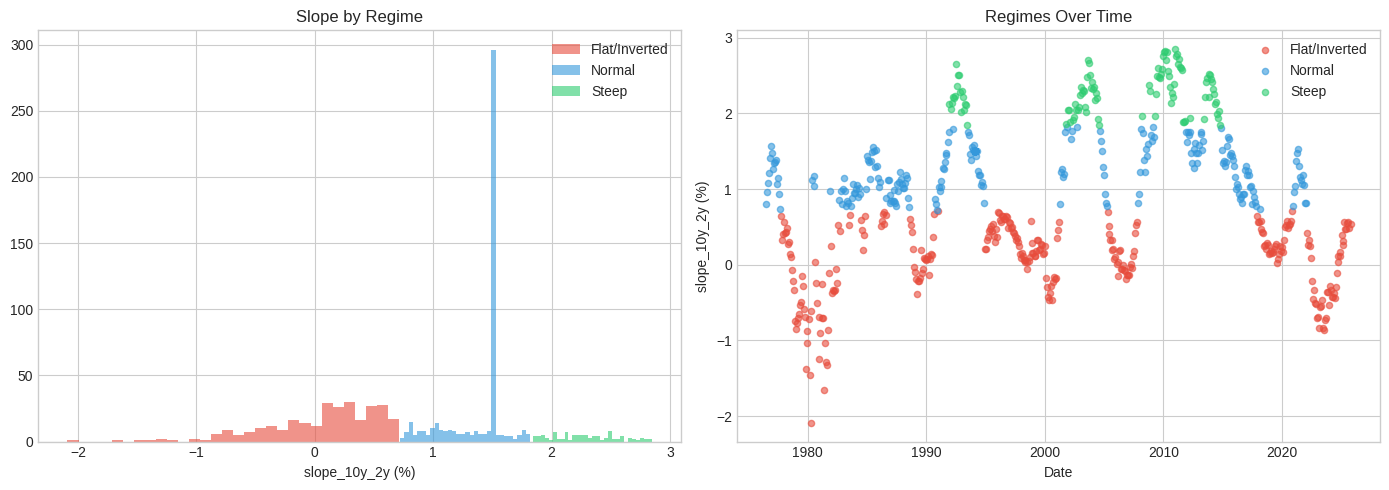

In [7]:
# Visualize regimes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
regime_colors = ['#e74c3c', '#3498db', '#2ecc71']

for regime in range(N_REGIMES):
    mask = events_df['regime'] == regime
    axes[0].hist(events_df.loc[mask, BACKGROUND_VAR], bins=30, alpha=0.6, label=REGIME_NAMES[regime], color=regime_colors[regime])
    axes[1].scatter(events_df.loc[mask, 'date'], events_df.loc[mask, BACKGROUND_VAR], alpha=0.6, label=REGIME_NAMES[regime], color=regime_colors[regime], s=20)

axes[0].set_xlabel(f'{BACKGROUND_VAR} (%)'); axes[0].set_title('Slope by Regime'); axes[0].legend()
axes[1].set_xlabel('Date'); axes[1].set_ylabel(f'{BACKGROUND_VAR} (%)'); axes[1].set_title('Regimes Over Time'); axes[1].legend()
plt.tight_layout()
plt.show()

In [8]:
# Step 4: Train/Test Split
train_df, test_df = create_train_test_split(events_df, test_size=TEST_SIZE, min_train_size=50)

print('='*60)
print('TRAIN/TEST SPLIT (70/30)')
print('='*60)
print(f'Training: {len(train_df)} events ({len(train_df)/len(events_df)*100:.0f}%)')
print(f'Test: {len(test_df)} events ({len(test_df)/len(events_df)*100:.0f}%)')
print(f'Train range: {train_df["date"].min().date()} to {train_df["date"].max().date()}')
print(f'Test range: {test_df["date"].min().date()} to {test_df["date"].max().date()}')

print('\nRegime Distribution:')
print(f'{"Regime":<20} {"Train":>8} {"Test":>8}')
for r in range(N_REGIMES):
    print(f'{REGIME_NAMES[r]:<20} {(train_df["regime"]==r).sum():>8} {(test_df["regime"]==r).sum():>8}')

print('\nBin Distribution:')
print(f'{"Bin":<30} {"Train":>8} {"Test":>8}')
for i in range(len(BIN_LABELS)):
    print(f'{BIN_LABELS[i]:<30} {(train_df["delta_y_bin"]==i).sum():>8} {(test_df["delta_y_bin"]==i).sum():>8}')

2025-12-03 19:09:06 - src.models.prepare_data - INFO - Train/test split: 616 train, 264 test
2025-12-03 19:09:06 - src.models.prepare_data - INFO - Train date range: 1976-06-22 00:00:00 to 2003-10-16 00:00:00
2025-12-03 19:09:06 - src.models.prepare_data - INFO - Test date range: 2003-11-18 00:00:00 to 2025-10-24 00:00:00
TRAIN/TEST SPLIT (70/30)
Training: 616 events (70%)
Test: 264 events (30%)
Train range: 1976-06-22 to 2003-10-16
Test range: 2003-11-18 to 2025-10-24

Regime Distribution:
Regime                  Train     Test
Flat/Inverted             171      112
Normal                    406       91
Steep                      39       61

Bin Distribution:
Bin                               Train     Test
Large Down (<-10bp)                  33       17
Small Down (-10 to -3bp)             76       51
Neutral (-3 to +3bp)                123      141
Small Up (+3 to +10bp)              363       41
Large Up (>+10bp)                    21       14


In [9]:
# Step 5: Train Per-Regime Classifiers
print('='*60)
print('TRAINING PER-REGIME CLASSIFIERS')
print('='*60)
print(f'Features: {FEATURE_COLS}')
print(f'Target: delta_y_bin ({len(BIN_LABELS)} classes)\n')

regime_classifiers = {}
for regime in range(N_REGIMES):
    regime_df = train_df[train_df['regime'] == regime].dropna(subset=FEATURE_COLS + ['delta_y_bin'])
    if len(regime_df) < 10:
        print(f'Regime {regime}: Only {len(regime_df)} samples - using prior')
        regime_classifiers[regime] = None
        continue
    
    X, y = regime_df[FEATURE_COLS].values, regime_df['delta_y_bin'].values
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_split=5, min_samples_leaf=3, random_state=42)
    clf.fit(X, y)
    regime_classifiers[regime] = clf
    
    train_acc = accuracy_score(y, clf.predict(X))
    print(f'Regime {regime} ({REGIME_NAMES[regime]}): {len(regime_df)} samples, train acc: {train_acc:.3f}')

TRAINING PER-REGIME CLASSIFIERS
Features: ['S_CPI', 'slope_10y_2y']
Target: delta_y_bin (5 classes)

Regime 0 (Flat/Inverted): 171 samples, train acc: 0.830
Regime 1 (Normal): 405 samples, train acc: 0.970
Regime 2 (Steep): 39 samples, train acc: 1.000


In [10]:
# Step 6: TEST SET EVALUATION
print('='*60)
print('TEST SET EVALUATION')
print('='*60)

all_y_true, all_y_pred = [], []
per_regime_results = {}

for regime in range(N_REGIMES):
    clf = regime_classifiers[regime]
    regime_df = test_df[test_df['regime'] == regime].dropna(subset=FEATURE_COLS + ['delta_y_bin'])
    if len(regime_df) == 0: continue
    
    X, y_true = regime_df[FEATURE_COLS].values, regime_df['delta_y_bin'].values
    y_pred = clf.predict(X) if clf else np.full_like(y_true, train_df['delta_y_bin'].mode()[0])
    
    acc = accuracy_score(y_true, y_pred)
    per_regime_results[regime] = {'y_true': y_true, 'y_pred': y_pred, 'acc': acc}
    all_y_true.extend(y_true); all_y_pred.extend(y_pred)
    print(f'Regime {regime} ({REGIME_NAMES[regime]}): {len(regime_df)} samples, acc: {acc:.3f}')

all_y_true, all_y_pred = np.array(all_y_true), np.array(all_y_pred)
overall_acc = accuracy_score(all_y_true, all_y_pred)
print(f'\n*** OVERALL TEST ACCURACY: {overall_acc:.3f} ({overall_acc*100:.1f}%) ***')

TEST SET EVALUATION
Regime 0 (Flat/Inverted): 112 samples, acc: 0.348
Regime 1 (Normal): 91 samples, acc: 0.352
Regime 2 (Steep): 61 samples, acc: 0.393

*** OVERALL TEST ACCURACY: 0.360 (36.0%) ***


In [11]:
# PER-BIN METRICS: Precision, Recall, F1
print('='*60)
print('PER-BIN CLASSIFICATION METRICS')
print('='*60)

precision, recall, f1, support = precision_recall_fscore_support(all_y_true, all_y_pred, labels=range(len(BIN_LABELS)), zero_division=0)

print(f'\n{"Bin":<30} {"Support":>8} {"Predicted":>10} {"Precision":>10} {"Recall":>10} {"F1":>10}')
print('-'*80)
for i in range(len(BIN_LABELS)):
    pred_count = (all_y_pred == i).sum()
    print(f'{BIN_LABELS[i]:<30} {support[i]:>8} {pred_count:>10} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f}')

print('\n' + '='*60)
print('INTERPRETATION')
print('='*60)
print('Precision = TP/(TP+FP) = When we predict this bin, how often correct?')
print('Recall = TP/(TP+FN) = Of actual instances, how many did we catch?')
print('F1 = Harmonic mean of Precision and Recall')

PER-BIN CLASSIFICATION METRICS

Bin                             Support  Predicted  Precision     Recall         F1
--------------------------------------------------------------------------------
Large Down (<-10bp)                  17          8      0.125      0.059      0.080
Small Down (-10 to -3bp)             51         67      0.224      0.294      0.254
Neutral (-3 to +3bp)                141        106      0.575      0.433      0.494
Small Up (+3 to +10bp)               41         75      0.240      0.439      0.310
Large Up (>+10bp)                    14          8      0.000      0.000      0.000

INTERPRETATION
Precision = TP/(TP+FP) = When we predict this bin, how often correct?
Recall = TP/(TP+FN) = Of actual instances, how many did we catch?
F1 = Harmonic mean of Precision and Recall


In [12]:
# FALSE POSITIVE / FALSE NEGATIVE ANALYSIS
print('='*60)
print('FALSE POSITIVE / FALSE NEGATIVE ANALYSIS')
print('='*60)

cm = confusion_matrix(all_y_true, all_y_pred, labels=range(len(BIN_LABELS)))

print(f'\n{"Bin":<25} {"TP":>6} {"FP":>6} {"FN":>6} {"TN":>6} {"FP Rate":>10} {"FN Rate":>10}')
print('-'*75)

for i in range(len(BIN_LABELS)):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - TP - FP - FN
    fp_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
    fn_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
    print(f'{BIN_LABELS[i]:<25} {TP:>6} {FP:>6} {FN:>6} {TN:>6} {fp_rate:>10.3f} {fn_rate:>10.3f}')

print('\nKey:')
print('  TP = Correctly predicted this bin')
print('  FP = Predicted this bin but was different (False Alarm)')
print('  FN = Was this bin but predicted different (Missed)')
print('  FP Rate = FP/(FP+TN) = Rate of false alarms')
print('  FN Rate = FN/(TP+FN) = Rate of misses = 1 - Recall')

FALSE POSITIVE / FALSE NEGATIVE ANALYSIS

Bin                           TP     FP     FN     TN    FP Rate    FN Rate
---------------------------------------------------------------------------
Large Down (<-10bp)            1      7     16    240      0.028      0.941
Small Down (-10 to -3bp)      15     52     36    161      0.244      0.706
Neutral (-3 to +3bp)          61     45     80     78      0.366      0.567
Small Up (+3 to +10bp)        18     57     23    166      0.256      0.561
Large Up (>+10bp)              0      8     14    242      0.032      1.000

Key:
  TP = Correctly predicted this bin
  FP = Predicted this bin but was different (False Alarm)
  FN = Was this bin but predicted different (Missed)
  FP Rate = FP/(FP+TN) = Rate of false alarms
  FN Rate = FN/(TP+FN) = Rate of misses = 1 - Recall


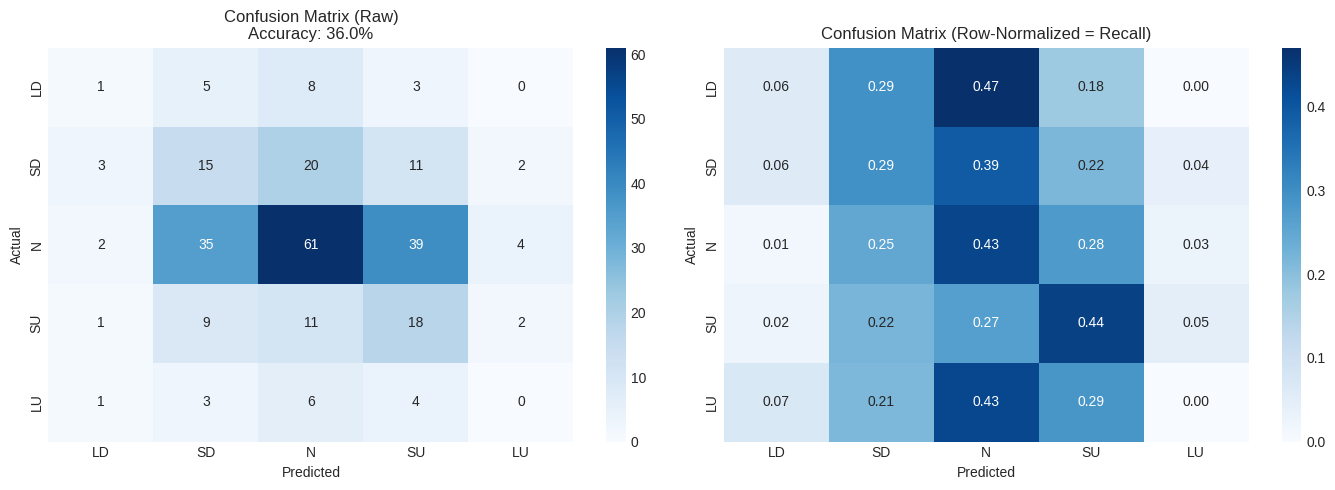


Bin Labels: LD=Large Down, SD=Small Down, N=Neutral, SU=Small Up, LU=Large Up


In [13]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=BIN_SHORT, yticklabels=BIN_SHORT)
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix (Raw)\nAccuracy: {overall_acc:.1%}')

cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], xticklabels=BIN_SHORT, yticklabels=BIN_SHORT)
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Row-Normalized = Recall)')

plt.tight_layout()
plt.show()
print('\nBin Labels: LD=Large Down, SD=Small Down, N=Neutral, SU=Small Up, LU=Large Up')

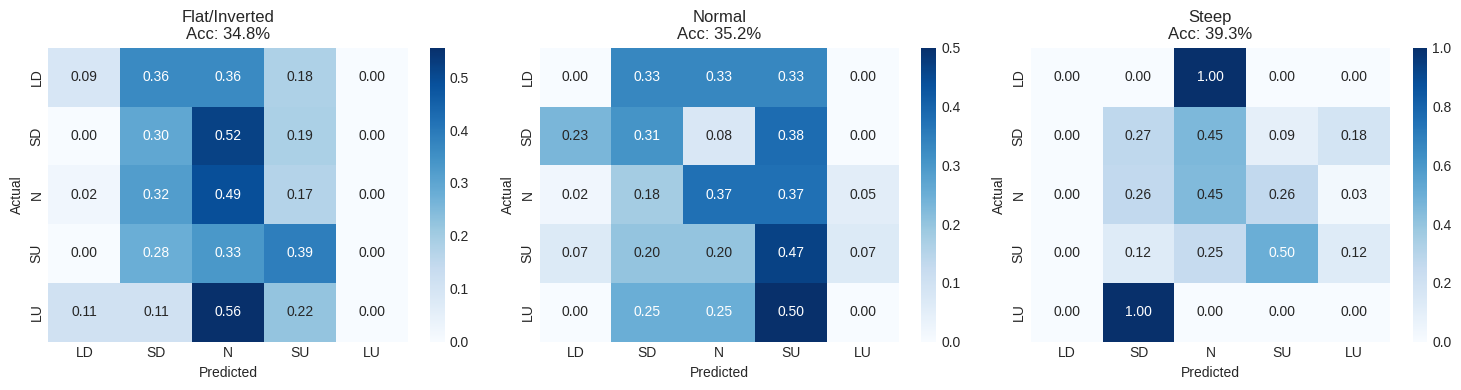

In [14]:
# Per-Regime Confusion Matrices
fig, axes = plt.subplots(1, N_REGIMES, figsize=(5*N_REGIMES, 4))

for regime in range(N_REGIMES):
    ax = axes[regime]
    if regime in per_regime_results:
        y_true, y_pred = per_regime_results[regime]['y_true'], per_regime_results[regime]['y_pred']
        cm_r = confusion_matrix(y_true, y_pred, labels=range(len(BIN_LABELS)))
        cm_norm = cm_r.astype('float') / (cm_r.sum(axis=1, keepdims=True) + 1e-10)
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax, xticklabels=BIN_SHORT, yticklabels=BIN_SHORT)
        ax.set_title(f'{REGIME_NAMES[regime]}\nAcc: {per_regime_results[regime]["acc"]:.1%}')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

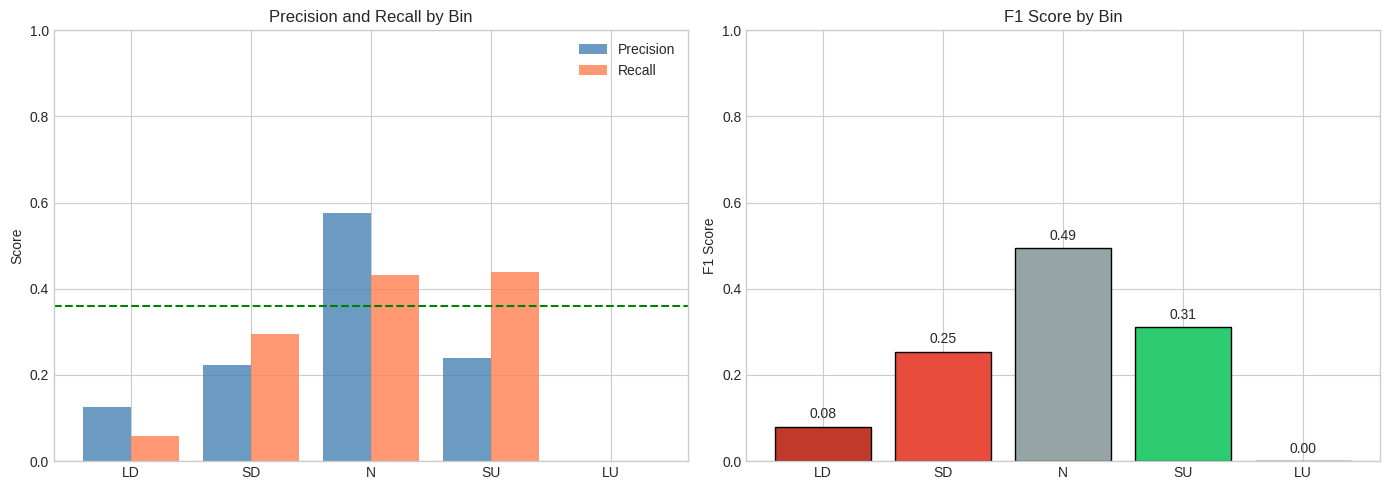

In [15]:
# Precision/Recall/F1 Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(BIN_LABELS))

ax1 = axes[0]
ax1.bar(x - 0.2, precision, 0.4, label='Precision', color='steelblue', alpha=0.8)
ax1.bar(x + 0.2, recall, 0.4, label='Recall', color='coral', alpha=0.8)
ax1.set_xticks(x); ax1.set_xticklabels(BIN_SHORT)
ax1.set_ylabel('Score'); ax1.set_ylim(0, 1); ax1.legend()
ax1.axhline(y=overall_acc, color='green', linestyle='--', label=f'Overall: {overall_acc:.2f}')
ax1.set_title('Precision and Recall by Bin')

ax2 = axes[1]
colors_f1 = ['#c0392b', '#e74c3c', '#95a5a6', '#2ecc71', '#27ae60']
bars = ax2.bar(x, f1, color=colors_f1, edgecolor='black')
ax2.set_xticks(x); ax2.set_xticklabels(BIN_SHORT)
ax2.set_ylabel('F1 Score'); ax2.set_ylim(0, 1)
for bar, score in zip(bars, f1): ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.2f}', ha='center')
ax2.set_title('F1 Score by Bin')

plt.tight_layout()
plt.show()

In [16]:
# Step 7: Markov Transition Matrix
def build_transition_matrix(df, n_regimes):
    df = df.sort_values('date').reset_index(drop=True)
    counts = np.zeros((n_regimes, n_regimes))
    regimes = df['regime'].values
    for t in range(len(regimes)-1): counts[int(regimes[t]), int(regimes[t+1])] += 1
    counts += 0.1
    return counts / counts.sum(axis=1, keepdims=True)

transition_matrix = build_transition_matrix(train_df, N_REGIMES)

print('='*60)
print('MARKOV TRANSITION MATRIX P(R_{t+1} | R_t)')
print('='*60)
print(f'\n{"From/To":<15}', end='')
for j in range(N_REGIMES): print(f'{REGIME_NAMES[j]:>15}', end='')
print(); print('-'*60)
for i in range(N_REGIMES):
    print(f'{REGIME_NAMES[i]:<15}', end='')
    for j in range(N_REGIMES): print(f'{transition_matrix[i,j]:>15.3f}', end='')
    print()

eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
stationary_dist = np.real(eigenvectors[:, np.argmin(np.abs(eigenvalues - 1.0))])
stationary_dist = stationary_dist / stationary_dist.sum()
print(f'\nStationary Distribution:')
for i in range(N_REGIMES): print(f'  {REGIME_NAMES[i]}: {stationary_dist[i]:.3f}')

MARKOV TRANSITION MATRIX P(R_{t+1} | R_t)

From/To          Flat/Inverted         Normal          Steep
------------------------------------------------------------
Flat/Inverted            0.940          0.059          0.001
Normal                   0.025          0.960          0.015
Steep                    0.003          0.133          0.864

Stationary Distribution:
  Flat/Inverted: 0.275
  Normal: 0.652
  Steep: 0.073


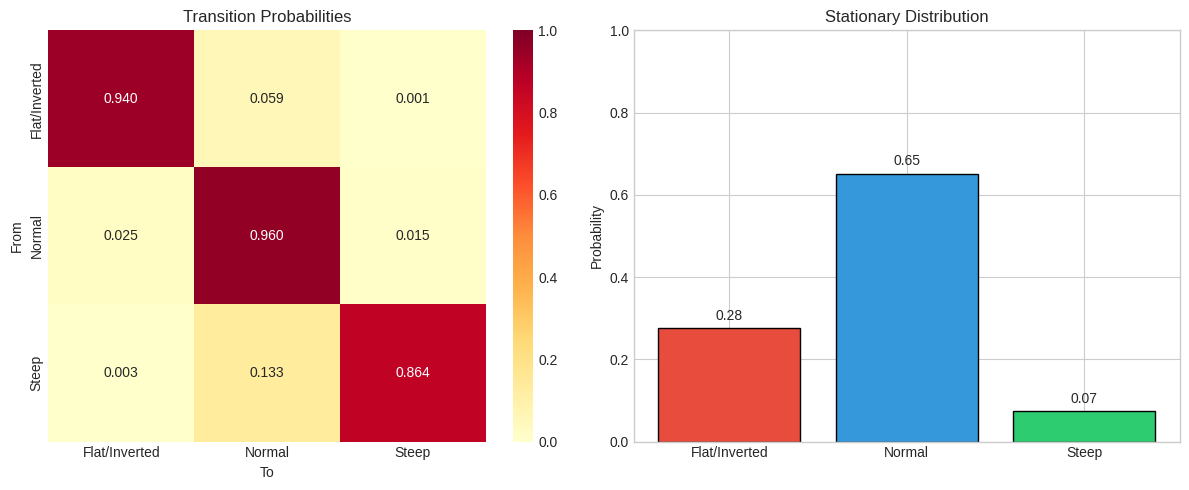

In [17]:
# Transition Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
regime_colors = ['#e74c3c', '#3498db', '#2ecc71']

sns.heatmap(transition_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0], xticklabels=REGIME_NAMES, yticklabels=REGIME_NAMES, vmin=0, vmax=1)
axes[0].set_xlabel('To'); axes[0].set_ylabel('From'); axes[0].set_title('Transition Probabilities')

bars = axes[1].bar(REGIME_NAMES, stationary_dist, color=regime_colors, edgecolor='black')
axes[1].set_ylim(0, 1); axes[1].set_ylabel('Probability'); axes[1].set_title('Stationary Distribution')
for bar, prob in zip(bars, stationary_dist): axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{prob:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [18]:
# Step 8: Prediction Function & Demo
def predict_yield_bin_distribution(S_CPI, background_val, R_prev, classifiers, trans_mat, n_classes=5):
    regime_prior = trans_mat[R_prev]
    X = np.array([[S_CPI, background_val]])
    regime_probs = np.zeros((len(trans_mat), n_classes))
    for k in range(len(trans_mat)):
        clf = classifiers.get(k)
        if clf: regime_probs[k] = clf.predict_proba(X)[0]
        else: regime_probs[k] = np.ones(n_classes) / n_classes
    mixed = np.dot(regime_prior, regime_probs)
    return mixed / mixed.sum(), regime_prior

print('='*70)
print('DEMONSTRATION: PREDICTIONS ON TEST EVENTS')
print('='*70)

demo_results = []
for idx in [0, len(test_df)//4, len(test_df)//2, 3*len(test_df)//4, len(test_df)-1]:
    event = test_df.iloc[idx]
    R_prev = int(test_df.iloc[idx-1]['regime']) if idx > 0 else int(train_df.iloc[-1]['regime'])
    probs, _ = predict_yield_bin_distribution(event['S_CPI'], event[BACKGROUND_VAR], R_prev, regime_classifiers, transition_matrix)
    pred, actual = np.argmax(probs), int(event['delta_y_bin'])
    
    print(f'\n{"─"*70}')
    print(f'Event: {event["date"].date()} | CPI: {event["cpi_shock_mom"]:.3f}% | Slope: {event[BACKGROUND_VAR]:.2f}%')
    print(f'Actual: {event[yield_change_col]*100:.1f}bp → Bin {actual} ({BIN_SHORT[actual]})')
    print(f'Probabilities: {" | ".join([f"{BIN_SHORT[i]}:{probs[i]:.2f}" for i in range(len(probs))])}')
    print(f'Predicted: Bin {pred} ({BIN_SHORT[pred]}) → {"✓ CORRECT" if pred == actual else "✗ WRONG"}')
    demo_results.append((probs, actual, pred, event))

DEMONSTRATION: PREDICTIONS ON TEST EVENTS

──────────────────────────────────────────────────────────────────────
Event: 2003-11-18 | CPI: -0.108% | Slope: 2.34%
Actual: 3.0bp → Bin 3 (SU)
Probabilities: LD:0.00 | SD:0.23 | N:0.07 | SU:0.65 | LU:0.04
Predicted: Bin 3 (SU) → ✓ CORRECT

──────────────────────────────────────────────────────────────────────
Event: 2009-05-15 | CPI: 0.101% | Slope: 2.26%
Actual: 1.0bp → Bin 2 (N)
Probabilities: LD:0.00 | SD:0.31 | N:0.06 | SU:0.61 | LU:0.01
Predicted: Bin 3 (SU) → ✗ WRONG

──────────────────────────────────────────────────────────────────────
Event: 2014-11-20 | CPI: -0.020% | Slope: 1.81%
Actual: -1.0bp → Bin 2 (N)
Probabilities: LD:0.00 | SD:0.11 | N:0.16 | SU:0.05 | LU:0.68
Predicted: Bin 4 (LU) → ✗ WRONG

──────────────────────────────────────────────────────────────────────
Event: 2020-05-12 | CPI: -0.792% | Slope: 0.52%
Actual: 0.0bp → Bin 2 (N)
Probabilities: LD:0.11 | SD:0.23 | N:0.43 | SU:0.22 | LU:0.02
Predicted: Bin 2 (N) → ✓ CO

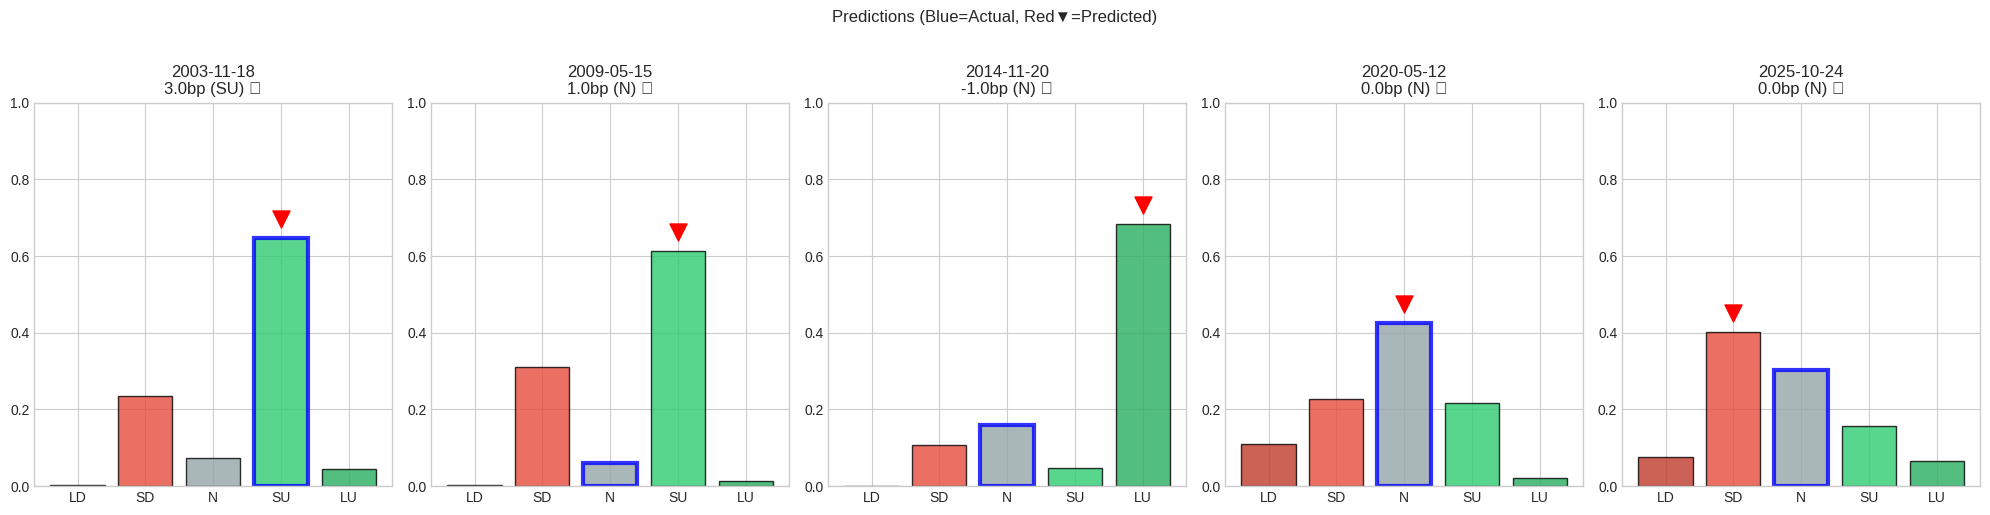

In [19]:
# Demo Visualization
fig, axes = plt.subplots(1, len(demo_results), figsize=(4*len(demo_results), 5))
colors_bins = ['#c0392b', '#e74c3c', '#95a5a6', '#2ecc71', '#27ae60']

for ax, (probs, actual, pred, event) in zip(axes, demo_results):
    bars = ax.bar(range(len(BIN_LABELS)), probs, color=colors_bins, edgecolor='black', alpha=0.8)
    bars[actual].set_edgecolor('blue'); bars[actual].set_linewidth(3)
    ax.scatter(pred, probs[pred] + 0.05, marker='v', color='red', s=150, zorder=5)
    ax.set_xticks(range(len(BIN_LABELS))); ax.set_xticklabels(BIN_SHORT)
    ax.set_ylim(0, 1)
    correct = '✓' if pred == actual else '✗'
    ax.set_title(f'{event["date"].date()}\n{event[yield_change_col]*100:.1f}bp ({BIN_SHORT[actual]}) {correct}')

plt.suptitle('Predictions (Blue=Actual, Red▼=Predicted)', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# FINAL SUMMARY
print('='*70)
print('FINAL SUMMARY')
print('='*70)

print(f'\nDATASET: {len(events_df)} events | Train: {len(train_df)} | Test: {len(test_df)}')
print(f'\nOVERALL TEST ACCURACY: {overall_acc:.1%}')
print(f'Random baseline (5 classes): 20.0%')
print(f'Lift over random: {(overall_acc/0.2 - 1)*100:.0f}%')

print(f'\nPER-BIN PERFORMANCE:')
print(f'{"Bin":<30} {"Precision":>10} {"Recall":>10} {"F1":>10}')
print('-'*62)
for i in range(len(BIN_LABELS)):
    print(f'{BIN_LABELS[i]:<30} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f}')

print(f'\nBest F1: {BIN_LABELS[np.argmax(f1)]} ({f1.max():.3f})')
print(f'Most common actual: {BIN_LABELS[np.argmax(support)]} ({support.max()} instances)')

FINAL SUMMARY

DATASET: 880 events | Train: 616 | Test: 264

OVERALL TEST ACCURACY: 36.0%
Random baseline (5 classes): 20.0%
Lift over random: 80%

PER-BIN PERFORMANCE:
Bin                             Precision     Recall         F1
--------------------------------------------------------------
Large Down (<-10bp)                 0.125      0.059      0.080
Small Down (-10 to -3bp)            0.224      0.294      0.254
Neutral (-3 to +3bp)                0.575      0.433      0.494
Small Up (+3 to +10bp)              0.240      0.439      0.310
Large Up (>+10bp)                   0.000      0.000      0.000

Best F1: Neutral (-3 to +3bp) (0.494)
Most common actual: Neutral (-3 to +3bp) (141 instances)
